In [38]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

# Problem 1

In [39]:
# 1 

T_1 = np.array([0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10])
R_1 = np.array([0.0334, 0.0352, 0.0375, 0.0392, 0.0405, 0.0422, 0.0433, 0.0445, 0.0451, 0.0455, 0.0459, 0.0462])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 213
         Function evaluations: 446
Parameters from the fit without sigma: [0.03180639 1.99399722 0.09407269]. SE of the fit: 2.6218546289522547e-09


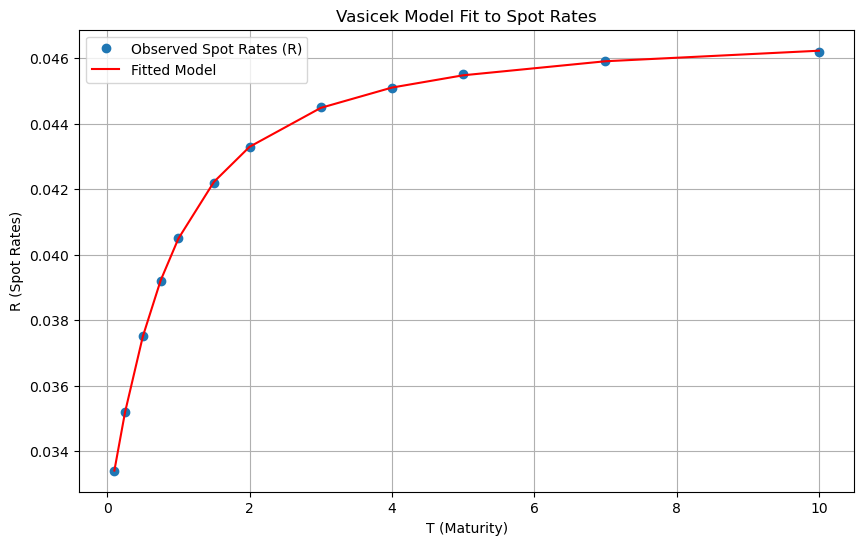

In [40]:
r0 = 0.038
a = 1.2 
b = 0.07
sigma = 0.04


# i) 
param_0 = r0, a, b 
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R_1,T_1),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit without sigma: {result.x}. SE of the fit: {result.fun}")
r0_hat, a_hat, b_hat = result.x


#ii) 
R_vaci = fid.spot_rate_vasicek(r0_hat,a_hat,b_hat, sigma, T_1)

plt.figure(figsize=(10, 6))
plt.plot(T_1, R_1, 'o', label='Observed Spot Rates (R)')
plt.plot(T_1, R_vaci, '-', label='Fitted Model', color='red')
plt.xlabel('T (Maturity)')
plt.ylabel('R (Spot Rates)')
plt.title('Vasicek Model Fit to Spot Rates')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# 2b) 
T_swap = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6])
p_swap = fid.zcb_price_vasicek(r0_hat, a_hat, b_hat, sigma, T_swap)

#i) 
swap_rate_2b, accrual_factor_2b = fid.swap_rate_from_zcb_prices(0,0,6,"semiannual", T_swap,p_swap)
print(f"Par swap rate {swap_rate_2b}")
print("Accrual factor", accrual_factor_2b)

#ii) 
caplet_2b = fid.caplet_prices_vasicek(sigma, swap_rate_2b, a_hat, T_swap,p_swap)
caplet_sum_2b = np.sum(caplet_2b)
print(f"Caplet array: {caplet_2b}")
print(f"Caplet sum {caplet_sum_2b}")


Par swap rate 0.04609464535672411
Accrual factor 5.204470259096905
Caplet array: [0.         0.         0.00243325 0.00259449 0.00261075 0.00257745
 0.00252743 0.00247228 0.00241616 0.00236053 0.0023059  0.00225242]
Caplet sum 0.02455065323278241


2c)
The interest rate swap eliminates all uncertainty about fixed future coupon payments. However, this option also has no upside in that the investor will not benefit if future 6M EURIBOR fixings are low. The interest rate cap prevents interest rate payments from becoming very large but retains the upside that the client will benefit from low future EURIBOR fixings. Therefore, there is nothing surprising about the fact that choosing the interest rate cap comes at a cost. 

# Problem 2

In [47]:
# 2a) 
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.04110}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12,
"rate": 0.04358},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03295},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03418},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03531},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03635},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03731},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03819},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03900},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03975}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03824,
"float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04083, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04242, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04346, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04468, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04561, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.04633, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.04667, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.04700, "float_freq":
"semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

In [ ]:
# i) 
T = [0.5, 1, 3, 5 ,10, 20, 30]
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_6m = np.array([i*0.5 for i in range(0,61)])
p_inter_mat, R_inter_mat, f_inter_mat, T_inter_mat = fid.zcb_curve_interpolate(T,T_fit,R_fit,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_6m,T_fit,R_fit,interpolation_options = interpolation_options)
print("Zero coupon spot rates:", R_inter_mat)

 

Zero coupon spot rates: [0.0406834  0.03882483 0.04051578 0.04323658 0.04549467 0.04664345
 0.04702701]


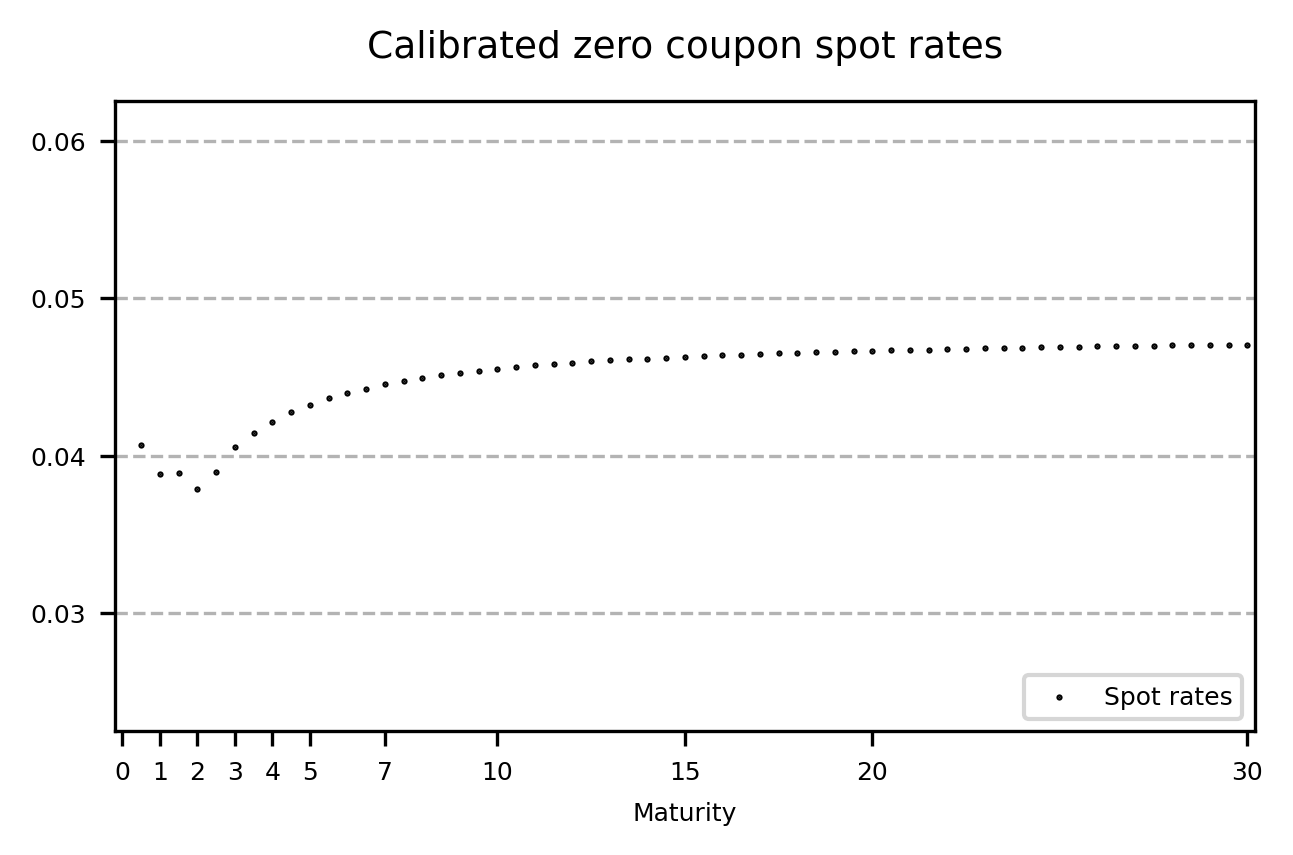

In [52]:
# ii) 
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0.0225,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
# p2 = ax.scatter(T_inter, p_inter, s = 1, color = 'red', marker = ".",label="ZCB rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

In [63]:
# 2b) 

R_swap_rates = []
for i in range(2,61):
    R_swap_2b, S_swap_2b = fid.swap_rate_from_zcb_prices(0,0,T_6m[i],"semiannual",T_inter,p_inter, "semiannual")
    R_swap_rates.append(R_swap_2b)
print(len(R_swap_rates))
print(len(T_6m))



59
61


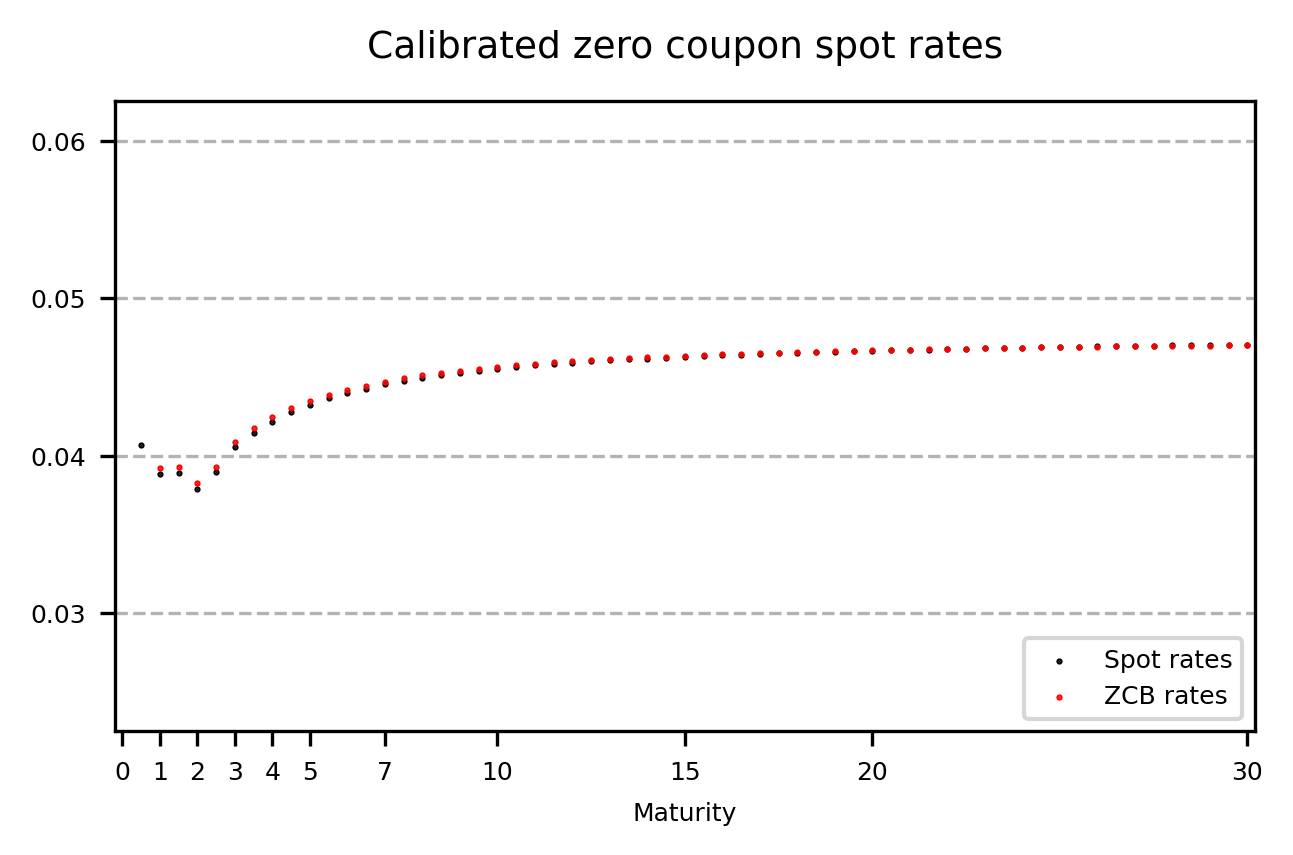

In [65]:
# i)

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0.0225,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_6m[2:], R_swap_rates, s = 1, color = 'red', marker = ".",label="ZCB rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

ii) 
They are very close. The swap rates are almost identical to the spot rates

iii) 
Zero coupon spot rates and par swap rates for same maturities are almost always very close. The main reason for this result is that a swap and a zero coupon bond on average, over the life of these securities, have very similar cashflows. A zero coupon bond pays no coupons and the net coupon to a swap being the difference between a fixed and a floating rate is on average

In [79]:
# 2c)  
K_2c = 0.047
swap_rate_2c, accrual_factor_2c = fid.swap_rate_from_zcb_prices(0,0,6,"semiannual", T_6m,p_inter)
PnL = accrual_factor_2c*(0.047-swap_rate_2c)
print("Swap rate", swap_rate_2c)
print("Profit n Loss:", PnL)

# We can check this by calculating the price now: 
price_now = (1-p_inter[12]-sum(p_inter[1:13]*0.5*K_2c))
print(price_now)

Swap rate 0.04417686002049361
Profit n Loss: 0.01482160410028848
-0.014821604100288488


ii) 
A receiver swap is positioned for falling interest rates and since the colleague lost money on his position, we can only assume that rates have risen since he entered into the swap. The 6Y par swap rate is now 0.05135 and hence, the par swap rate is today higher than the par swap rate of 0.04700 when the colleague entered into the swap. This corresponds to a rate increase of roughly 41 bps which when multiplied by the accrual factor slightly above 5 does indeed yield a little more than 200 bps.

Remember, that our numbers are reversed. Therefore, our rates has falling since our colleague has earned on his position. This is because as stated, that a receiver swap is positioned for falling interest rates!

# Problem 3

0.0487002882976103
4.0717299


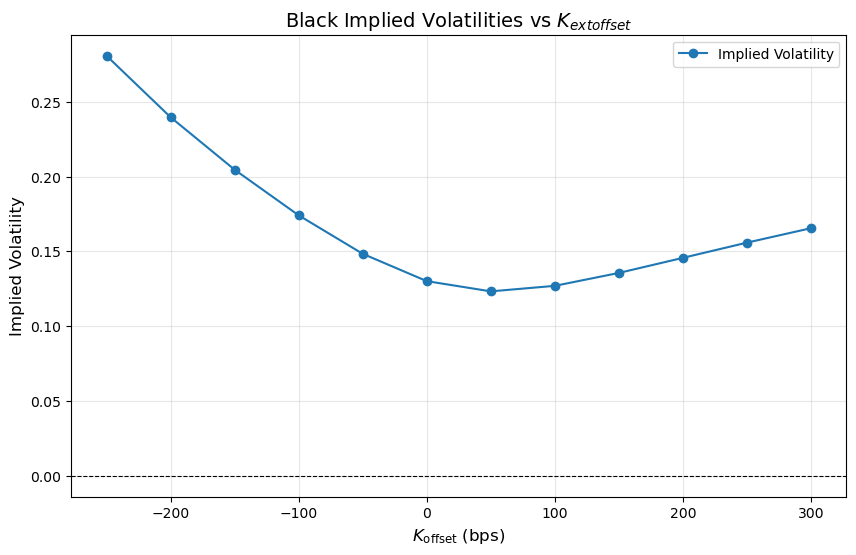

In [ ]:
# 3a) 

T_3a = np.array([0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 6.50, 7.00])
ZCB_3a = np.array([0.98314916, 0.96478677, 0.94539738, 0.92535353, 0.90493951, 0.88437071, 0.86380916, 0.84337571, 0.8231596, 0.80322594, 0.78362142, 0.76437872, 0.74551992, 0.72705911])
offset = np.array([-300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300])
pi_swap = np.array([0.12256859, 0.10253932, 0.08273803, 0.0633625, 0.04480655, 0.02793572, 0.0145331, 0.00650867, 0.0030062, 0.00158778, 0.00094974, 0.00062285, 0.00043427])

swap_rate_3a, acc_factor_3a = fid.swap_rate_from_zcb_prices(0,2,7,"semiannual", T_3a,ZCB_3a, "semiannual")
print(swap_rate_3a)
print(acc_factor_3a)

R_ATM = swap_rate_3a
K = R_ATM + offset / 10000

black_iv = []
# T here denotes the expiry of the option not the swap. I.e the start of the swap
# R is the current swap rate
for i, K_i in enumerate(K):
    C = pi_swap[i]  # Price of the swaption
    implied_vol = fid.black_swaption_iv(C=C, T=2, K=K_i, S=acc_factor_3a, R=swap_rate_3a, type="call")
    black_iv.append(implied_vol)
    
plt.figure(figsize=(10, 6))
plt.plot(offset, black_iv, marker='o', linestyle='-', label='Implied Volatility')

# Add labels and title
plt.xlabel(r"$K_{\text{offset}}$ (bps)", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.title("Black Implied Volatilities vs $K_{\text{offset}}$", fontsize=14)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--') 
plt.grid(alpha=0.3)
plt.legend()

# Show the plot
plt.show()


ii) There is indeed a ’smirk’ in implied volatilities clearly indicating that market prices are not equivalent to what would arise in a Black’s model. The pricing measure chosen by the market is not compatible with the 2Y 5Y forward par swap rate following a log-normal distribution. The distribution implied by the measure chosen by the market has more fat tails and displays more left skewness than that of a log-normal random variable. This is a finding that is very much consistent with typical market behavior.

In [ ]:
# 3b) 

